In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import os
import time

In [7]:
from IPython import display

In [8]:
import numpy as np

In [9]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Train 데이터를 불러옵니다.
train = pd.read_csv('C:/Users/ufoio/Documents/AI/Semiconductor_dacon/train.csv')
# Test 데이터를 불러옵니다.
test = pd.read_csv('C:/Users/ufoio/Documents/AI/Semiconductor_dacon/test.csv')

In [10]:
layer_col = ['layer_1', 'layer_2', 'layer_3', 'layer_4']
light_col = set(train.columns) - set(['layer_1', 'layer_2', 'layer_3', 'layer_4'])

light_col = list(train.columns.drop(['layer_1', 'layer_2', 'layer_3', 'layer_4']))

light = train[light_col]#.drop(['0'], axis=1)
layer = train[layer_col]

In [11]:
light_shaped = light.to_numpy().reshape(-1,226, 1, 1)

In [12]:
layer_shaped = layer.to_numpy().reshape(-1, 4)

In [85]:
class Generator(tf.keras.Model):
    """Build a generator that maps latent space to real space given conditions.
    G(z, c): (z, c) -> x
    """
    
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2DTranspose(256, ( 8, 1))
        self.conv2 = tf.keras.layers.Conv2DTranspose(128, (16, 1))
        self.conv3 = tf.keras.layers.Conv2DTranspose(64,  (32, 1))
        self.conv4 = tf.keras.layers.Conv2DTranspose(32,  (64, 1))
        self.conv5 = tf.keras.layers.Conv2DTranspose(1,  (110, 1), activation='relu')

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.activation = tf.keras.layers.LeakyReLU()
        
    def call(self, noise_inputs, conditions, training=True):
        """Run the model."""
        # noise_inputs: [1, 1, 100]
        # conditions: [1, 1, 10] (for MNIST)
        # inputs = 1 x 1 x (100 + 10) dim
        inputs = tf.concat([noise_inputs, conditions], axis=-1)
        
        conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
        conv1 = self.bn1(conv1, training=training)
        conv1 = self.activation(conv1, training=training)
        
        conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
        conv2 = self.bn2(conv2, training=training)
        conv2 = self.activation(conv2, training=training)
        
        conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
        conv3 = self.bn3(conv3, training=training)
        conv3 = self.activation(conv3, training=training)

        conv4 = self.conv4(conv3, training=training)            # conv3: [14, 14, 64]
        conv4 = self.bn4(conv4, training=training)
        conv4 = self.activation(conv4, training=training)

        generated_images = self.conv5(conv4, training=training) # generated_images: [28, 28, 1]
        
        generated_images = tf.abs(generated_images)
        
        return generated_images


In [86]:
class Discriminator(tf.keras.Model):
    """Build a discriminator that discriminate tuple (x, c) whether real or fake.
    D(x, c): (x, c) -> [0, 1]
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D( 64, ( 4, 1), 2) 
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(128, ( 4, 1), 2)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(256, ( 3, 1), 2) 
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(512, ( 3, 1), 2)
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(  1, (13, 1), 1)
        
        self.activation = tf.keras.layers.LeakyReLU()

    def call(self, image_inputs, conditions, training=True):
        """Run the model."""
        # image_inputs: [28, 28, 1]
        # conditions: 10 dim (for MNIST)
        # inputs: [28, 28, (1 + 10)]
        inputs = tf.concat([image_inputs, conditions * tf.ones([image_inputs.shape[0], 226, 1, 4])], axis=-1)
        
        conv1 = self.conv1(inputs)                          
        conv1 = self.bn1(conv1)
        conv1 = self.activation(conv1)

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(conv2)                     
        conv2 = self.activation(conv2)

        conv3 = self.conv3(conv2)                             
        conv3 = self.bn3(conv3)
        conv3 = self.activation(conv3)
        
        conv4 = self.conv4(conv3)                             
        conv4 = self.bn4(conv4)
        conv4 = self.activation(conv4)
        
        conv5 = self.conv5(conv4)
        conv5 = tf.keras.activations.sigmoid(conv5)
        
        discriminator_logits = tf.squeeze(conv5) # discriminator_logits: [1,]
        

        return discriminator_logits


In [87]:
generator = Generator()
discriminator = Discriminator()

In [88]:
bce = tf.losses.BinaryCrossentropy()

def GANLoss(logits, is_real=True):
    """Computes standard GAN loss between `logits` and `labels`.

    Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

    Returns:
    loss (`0-rank Tensor`): the standard GAN loss value. (binary_cross_entropy)
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return bce(labels, logits)

In [89]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss


In [90]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [91]:
model_name = 'cgan'
train_dir = os.path.join('train', model_name, 'exp1')

max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 1e-3
k = 1 # the number of step of learning D before learning G (Not used in this code)
num_classes = 4 # number of classes for MNIST
num_examples_to_generate = 1
noise_dim = 100

In [92]:
def convert_shape_and_type_for_labels(x, y):
    y = tf.reshape(y, shape=[1, 1, 4])
    y = tf.cast(y, dtype = tf.float32)
    
    x = tf.cast(x, dtype = tf.float32)
    return x, y

In [93]:
train_dataset = tf.data.Dataset.from_tensor_slices((light_shaped, layer_shaped))

train_dataset = train_dataset.shuffle(buffer_size=len(train))
train_dataset = train_dataset.map(convert_shape_and_type_for_labels)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)

N = len(train)

In [94]:
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)

In [70]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [71]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
const_random_vector_for_saving = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                   minval=-1.0, maxval=1.0)


In [72]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
  # generating noise from a uniform distribution
    noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, labels, training=True)

        real_logits = discriminator(images, labels, training=True)
        fake_logits = discriminator(generated_images, labels, training=True)

        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss


In [101]:
randindex = np.random.randint(len(train), size=num_examples_to_generate)

sample_condition = layer_shaped[randindex].astype('float32')
sample_condition = tf.reshape(sample_condition, [-1, 1, 1, num_classes])

In [102]:
import gc
gc.collect()

189037

Epochs: 0.85 global_step: 2700 loss_D: 1.4 loss_G: 0.684 (615.60 examples/sec; 0.416 sec/batch)


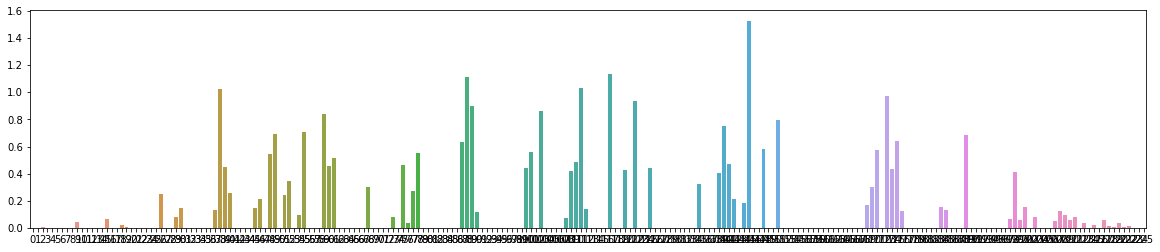

KeyboardInterrupt: 

In [104]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):

    for step, (images, labels) in enumerate(train_dataset):
        start_time = time.time()

        gen_loss, disc_loss = train_step(images, labels)
        global_step.assign_add(1)

        if global_step.numpy() % print_steps == 0:
            epochs = epoch + step / float(num_batches_per_epoch)
            duration = time.time() - start_time
            examples_per_sec = batch_size / float(duration)
            display.clear_output(wait=True)
            print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                    epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
            
            noise = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim], minval=-1.0, maxval=1.0)
            sample_images = generator(noise, sample_condition, training=False)
            
            for row in sample_images.numpy():
                fig, ax = plt.subplots(figsize=(20, 4))
                sns.barplot(y=row.reshape(-1), x=[i for i in range(226)], orient='v')
                plt.show()
            
    # saving (checkpoint) the model every save_epochs
    if (epoch + 1) % save_model_epochs == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

print('Training Done.')


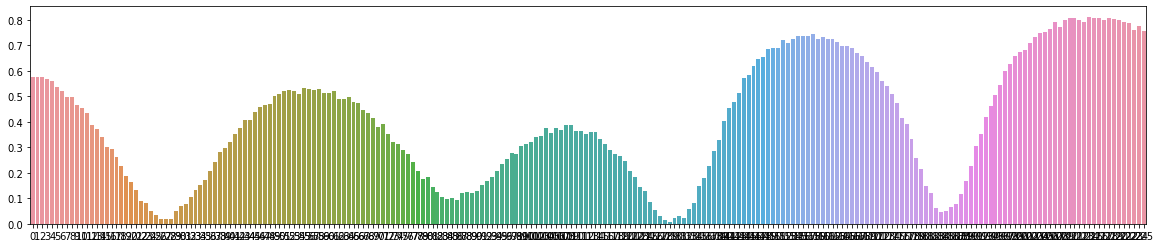

In [103]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(y=light_shaped[randindex].reshape(-1), x=[i for i in range(226)], orient='v')